# Adversarial attacks on 1D double well potential

In this notebook, we reproduce the example of adversarial attacks on the asymetric 1D double well shown in the supporting information of [our paper](https://arxiv.org/abs/2101.11588).

The notebook uses the models and the helper functions in the `robust` folder of this repo.

In [1]:
import sys
sys.path.append('..')

import robust as rb
import torch as ch
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

## Creating the 1D double well

Using the potentials available at the `robust` module, we created an asymetric 1D double well with the desired zeros, depth and offset. In particular, the equation for the potential is the following:

$$E(x) = 5 x^4 - 10 x^2 + 1.5 x$$

Then, the `potential` object creates the training set, the `true_potential` is used for the evaluation (e.g. the surrogate model, or analogous to a FF or DFT calculation). We also select the plotting range for the potentials, in order to achieve a better visualization for this work.

In [2]:
WELL_ZEROS = 1
WELL_DEPTH = 5
WELL_OFFSET = 3

ENERGY_THRESHOLD = -5.5

potential = rb.potentials.MaskedDoubleWell.from_zeros_and_depth(
    zeros=WELL_ZEROS,
    depth=WELL_DEPTH,
    offset=WELL_OFFSET,
    emax=ENERGY_THRESHOLD,
    energy_noise=0.0,
)

true_potential = rb.potentials.DoubleWell.from_zeros_and_depth(
    zeros=WELL_ZEROS,
    depth=WELL_DEPTH,
    offset=WELL_OFFSET,
)

In [3]:
PLOT_RANGE = 1.65

x = ch.linspace(-PLOT_RANGE * WELL_ZEROS, PLOT_RANGE * WELL_ZEROS, steps=500)

dset = rb.PotentialDataset(*potential(x))

../robust/data.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor).reshape(len(tensor), -1)
../robust/data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ch.tensor(tensor)


In [4]:
xplot = ch.linspace(-PLOT_RANGE * WELL_ZEROS, PLOT_RANGE * WELL_ZEROS, steps=250)
xplot, eplot, fplot = potential(xplot, clip=False, add_noise=False)
dplot = rb.PotentialDataset(xplot, eplot, fplot)

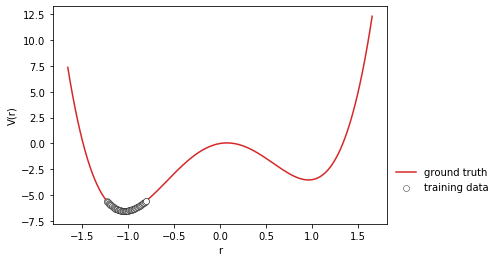

In [5]:
fig, ax = plt.subplots()

ax.plot(dplot.x, dplot.e, c='#d62728', label='ground truth', zorder=-1)
ax.scatter(dset.x, dset.e, alpha=0.8, c='w', edgecolor='k', linewidths=0.5, label='training data')

ax.set_xlabel('r')
ax.set_ylabel('V(r)')

ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.3))
plt.show()

## Training the models

Now, we select all hyperparameters of the models. The NN ensemble is generated from the `model_params`. The `loss_params` are used both for the training and adversarial loss, although the latter uses only the temperature. `score_params` uses some deduplication strategies, as explained in Sec. II-C of the paper. Afterwards, the initial pipeline (i.e. one loop cycle) is created, and the model is trained.

In [6]:
loss_params = {
    'energy_coef': 1,
    'forces_coef': 10,
    'temperature': 5,
}

model_params = {
    'input_dim': 1,
    'num_layers': 4,
    'layer_dim': 1024,
    'num_networks': 5
}

optim_params = {
    'lr': 1e-3,
}

train_params = {
    'max_epochs': 500,
    'batch_size': 35,
}

attack_params = {
    'delta_std': 1e-2,
    'optim_kws': optim_params,
}

score_params = {
    'UncertaintyPercentile': {'percentile': 80},
    'RmsdScore': {'threshold': 0.05},
    'ClusterScore': {'threshold': 0.01},
}

prefix = 'models_1D'

In [7]:
pipeline = rb.ForwardPipeline(
    dset,
    model_params,
    loss_params,
    optim_params,
    train_params,
    attack_params,
    name=f"{prefix}/gen_1",
)

# If you don't have a GPU, set DEVICE to 'cpu'
DEVICE = 0

In [8]:
loop = rb.actlearn.ActiveLearning(
    pipeline,
    true_potential,
    device=DEVICE,
    train_epochs=400,
    attack_epochs=400,
    scores=score_params,
    num_generations=5,
    name_prefix=prefix,
)

In [9]:
loop.loop()

ACT_LEARN: GEN 1: training model
 Time | Epoch | Learning rate | Train loss | Validation loss | MAE Energy | MAE Forces | GPU Memory (MB)


/home/dskoda/.conda/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type NnEnsemble. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dskoda/.conda/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dskoda/.conda/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type NnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dskoda/.conda/envs/htvs/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dense. It won't be checked for correctness upon loadi

47:33 |    25 |     1.000e-03 |   308.4541 |        330.1967 |     1.6394 |    24.3749 |             110
47:34 |    50 |     1.000e-03 |   293.2861 |        370.3626 |     6.7698 |    25.1993 |             110
47:36 |    75 |     1.000e-03 |   293.1133 |        361.4265 |     1.6487 |    25.0531 |             110
47:37 |   100 |     5.000e-04 |   292.1034 |        378.7480 |     1.4998 |    25.4975 |             110
47:38 |   125 |     5.000e-04 |   285.4125 |        356.6629 |     1.5071 |    24.7989 |             110
47:39 |   150 |     2.500e-04 |   256.1725 |        337.4133 |     1.4223 |    23.9928 |             110
47:41 |   175 |     2.500e-04 |    53.5154 |         72.0234 |     4.0867 |     9.6604 |             110
47:42 |   200 |     2.500e-04 |    16.6218 |         21.3815 |     1.4408 |     6.0609 |             110
47:44 |   225 |     2.500e-04 |    34.8462 |         20.6622 |     1.4408 |     6.2636 |             110
47:45 |   250 |     2.500e-04 |    12.6319 |         22

50:05 |   175 |     1.250e-04 |    72.8737 |          9.0123 |     5.0122 |     3.3005 |             616
50:06 |   200 |     1.250e-04 |    55.1938 |          8.0003 |     4.3317 |     2.9271 |             616
50:09 |   225 |     1.250e-04 |    39.0689 |          3.9875 |     3.5808 |     1.7839 |             616
50:10 |   250 |     1.250e-04 |    25.2409 |          2.1375 |     2.8146 |     1.2772 |             616
50:12 |   275 |     1.250e-04 |    14.5769 |          0.9565 |     2.0144 |     0.8646 |             616
50:14 |   300 |     1.250e-04 |     7.0177 |          0.3663 |     1.2796 |     0.5725 |             616
50:16 |   325 |     1.250e-04 |     3.1110 |          0.2318 |     0.8112 |     0.4910 |             616
50:17 |   350 |     1.250e-04 |     1.6242 |          0.1973 |     0.4703 |     0.5026 |             616
50:19 |   375 |     1.250e-04 |     0.8935 |          0.0865 |     0.3302 |     0.3395 |             616
50:21 |   400 |     1.250e-04 |     0.5282 |          0

## Plotting the evolution of the active learning loop

This plot reproduces Fig. S3 of the paper. It essentially shows all adversarial attacks and the evolution of the uncertainty/loss across generations.

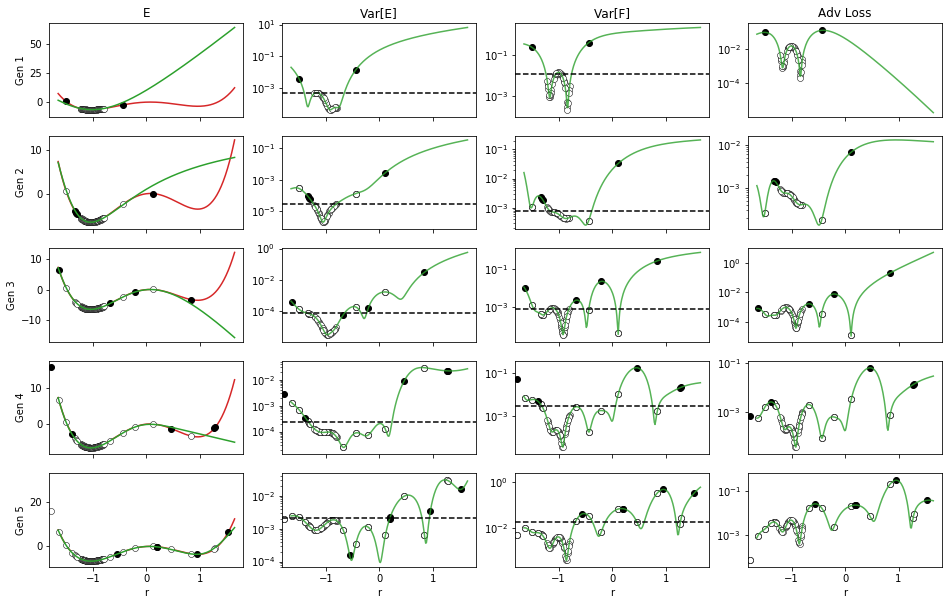

In [10]:
N_GENS = len(loop.generations)
N_PLOTS = 4
PERCENTILE = 80

fig, ax_fig = plt.subplots(N_GENS, N_PLOTS, figsize=(N_PLOTS * 4, N_GENS * 2), sharex=True)

for gen, ax_row in zip(loop.generations, ax_fig):
    pipeline = gen['pipeline']
    attacks = gen['attacks']
    attacks_truth = rb.PotentialDataset(*true_potential(attacks.x))

    train_model, _, _ = pipeline.evaluate(pipeline.train_loader, DEVICE)
    dplot_model, _, _ = pipeline.evaluate(dplot.get_loader(train_params['batch_size']), DEVICE)
    
    ax = ax_row[0]
    ax.plot(dplot.x, dplot.e, c='#d62728', label='ground truth', zorder=-1)
    ax.plot(dplot_model.x, dplot_model.e.mean(-1), c='#2ca02c', label='prediction')
    ax.scatter(
        pipeline.dset.x,
        pipeline.dset.e,
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data',
    )
    
    ax.scatter(
        pipeline.dset_train.x,
        pipeline.dset_train.e,
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data',
    )

    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x,
            attacks_truth.e,
            c='k',
            label='attacks',
        )

    ax = ax_row[1]
    ax.semilogy(dplot_model.x, dplot_model.e.var(-1), alpha=0.8, c='#2ca02c', label='prediction')
    ax.scatter(
        train_model.x,
        train_model.e.var(-1),
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data'
    )
        
    if len(attacks) > 0:
        ax.scatter(
            attacks.x,
            attacks.e.var(-1),
            c='k',
            label='attacks',
        )

    threshold = stats.scoreatpercentile(train_model.e.var(-1), PERCENTILE)

    xlim = ax.get_xlim()
    ax.plot(xlim, [threshold] * 2, 'k--', label=f'{PERCENTILE}th percentile')
    ax.set_xlim(xlim)

    ax = ax_row[2]
    ax.semilogy(dplot_model.x, dplot_model.f.var(-1), alpha=0.8, c='#2ca02c', label='prediction')
    ax.scatter(
        train_model.x,
        train_model.f.var(-1),
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data',
        zorder=2,
    )
    
    if len(attacks) > 0:
        ax.scatter(
            attacks.x,
            attacks.f.var(-1),
            c='k',
            label='attacks',
            zorder=2,
        )

    threshold = stats.scoreatpercentile(train_model.f.var(-1), PERCENTILE)
    if gen['generation'] == 1:
        first_gen_fthreshold = threshold
    
    xlim = ax.get_xlim()
    ax.plot(xlim, [threshold] * 2, 'k--', label=f'{PERCENTILE}th percentile')
    ax.set_xlim(xlim)

    ax = ax_row[3]
    adv_loss = pipeline.get_adv_loss()
    
    ax.semilogy(
        dplot_model.x,
        -adv_loss.loss_fn(dplot_model.x, dplot_model.e, dplot_model.f),
        alpha=0.8,
        c='#2ca02c',
        label='prediction'
    )
    ax.scatter(
        train_model.x,
        -adv_loss.loss_fn(train_model.x, train_model.e, train_model.f),
        c='w',
        linewidths=0.5,
        edgecolor='k',
        label='training data'
    )
    
    if len(attacks) > 0:
        ax.scatter(
            attacks.x,
            -adv_loss.loss_fn(attacks.x, attacks.e, attacks.f),
            c='k',
            label='attacks',
        )

ax_fig[0, 0].set_title('E')
ax_fig[0, 1].set_title('Var[E]')
ax_fig[0, 2].set_title('Var[F]')
ax_fig[0, 3].set_title('Adv Loss')

for i, ax in enumerate(ax_fig[:, 0], 1):
    ax.set_ylabel(f'Gen {i}')

for ax in ax_fig[-1, :]:
    ax.set_xlabel('r')

plt.show()